## 1. Setup & load the data

In [2]:
import pandas as pd
import numpy as np

# 1. Load raw data
df_raw = pd.read_csv("unclean_bbc_iplayer_dataset_5k.csv")

# Keep an untouched copy for reference if needed
df = df_raw.copy()

# Quick overview
print(df.head())
print(df.info())
print(df.describe(include="all"))

   show_id                  title        genre duration broadcast_date  \
0        1  Strictly Come Dancing  Documentary      NaN     27/04/2023   
1        2          Frozen Planet      Reality   90 min    25 Mar 2023   
2        3       Match of the Day        Drama   45 min     2023-01-16   
3        4  Strictly Come Dancing      Reality   30mins     08/01/2024   
4        5                 Luther  Documentary   90 min     18/03/2023   

   rating views  
0     NaN     ?  
1     NaN     ?  
2     NaN   NaN  
3     NaN     ?  
4     5.1     ?  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   show_id         5000 non-null   int64  
 1   title           5000 non-null   object 
 2   genre           5000 non-null   object 
 3   duration        4269 non-null   object 
 4   broadcast_date  5000 non-null   object 
 5   rating          1611 

In [3]:
df_raw.head()

,show_id,title,genre,duration,broadcast_date,rating,views
0,1,Strictly Come Dancing,Documentary,NaN,27/04/2023,NaN,?
1,2,Frozen Planet,Reality,90 min,25 Mar 2023,NaN,?
2,3,Match of the Day,Drama,45 min,2023-01-16,NaN,NaN
3,4,Strictly Come Dancing,Reality,30mins,08/01/2024,NaN,?
4,5,Luther,Documentary,90 min,18/03/2023,5.1,?


- `df_raw` is the original data (never modified).
- `df` is the working copy I’ll clean.
- Initial `head()`, `info()`, and `describe()` help identify:
- column types
- obvious missing data
- weird values (e.g., strings in numeric-like cols).

## 2. Detect and summarise missing values

In [4]:
def missing_values_report(data: pd.DataFrame) -> pd.DataFrame:
    """Return a summary of missing values per column."""
    missing_count = data.isna().sum()
    missing_pct = 100 * missing_count / len(data)
    report = pd.DataFrame({
        "missing_count": missing_count,
        "missing_pct": missing_pct.round(2)
    })
    return report.sort_values(by="missing_pct", ascending=False)

# First, normalise obvious missing indicators like 'N/A' and '?'
missing_like = ["N/A", "n/a", "NA", "na", "?", "", "None"]
df = df.replace(missing_like, np.nan)

mv_report_before = missing_values_report(df)
print(mv_report_before)

                missing_count  missing_pct
views                    3796        75.92
rating                   3389        67.78
duration                 1448        28.96
show_id                     0         0.00
title                       0         0.00
genre                       0         0.00
broadcast_date              0         0.00


- Many “missing” values are text placeholders like `"N/A"` or `"?"`.
- I standardise all missing-like tokens to `NaN` so pandas can handle them uniformly.
- `missing_values_report` provides a reusable summary for any dataset.

## 3. Standardise `broadcast_date` formats
The dataset has multiple date formats (e.g. 2023-03-01, 03/01/2023, Mar 1 2023).

### 3.1 Parse all dates robustly

In [5]:
# Keep a raw backup
df["broadcast_date_raw"] = df["broadcast_date"]

# Let pandas infer multiple date formats; coerce invalid to NaT
df["broadcast_date"] = pd.to_datetime(df["broadcast_date"], errors="coerce", dayfirst=True)


### 3.2 Check parsing success

In [6]:
num_nat = df["broadcast_date"].isna().sum()
print(f"Unparsed/invalid dates (NaT): {num_nat}")


Unparsed/invalid dates (NaT): 3770


In [7]:
print(df.loc[df["broadcast_date"].isna(), "broadcast_date_raw"].head(20))

1     25 Mar 2023
2      2023-01-16
5     02 Oct 2022
7     Oct 26 2022
8     May 03 2024
9      2023-08-02
10    Jun 07 2023
11    Jul 18 2022
12    May 04 2022
13    22 Aug 2023
14    Jan 15 2023
15     2022-02-26
16    Oct 07 2023
17     2023-12-18
20    Jan 18 2023
21    23 Aug 2023
22    Apr 11 2022
23    24 Apr 2022
26     2023-02-18
27     2022-06-28
Name: broadcast_date_raw, dtype: object


- `broadcast_date_raw` preserves the original string.
- `errors="coerce"` converts unparsable values into `NaT` (missing date), which I can treat as missing.
- `infer_datetime_format=True` lets pandas guess multiple formats automatically.
- I validate by counting how many become `NaT` and sampling them.

## 4. Clean and standardise `duration`
The column currently has things like `"45 min"`, `"60"`, `"30mins"`, `"90 min"`, `None`,`"?"`.
Goal: numeric duration in minutes.

### 4.1 Helper to parse durations

In [8]:
import re

def parse_duration_to_minutes(value):
    """
    Convert various 'duration' formats to numeric minutes.
    Returns float or NaN if not parseable.
    """
    if pd.isna(value):
        return np.nan
    
    if isinstance(value, (int, float)):
        # Already numeric -> assume minutes
        return float(value)
    
    text = str(value).strip().lower()
    
    # Remove obvious noise words
    text = text.replace("mins", "").replace("min", "").strip()
    
    # If now empty or weird
    if text in ["", "?", "na", "n/a", "none"]:
        return np.nan
    
    # Try to extract number
    match = re.search(r"(\d+(\.\d+)?)", text)
    if match:
        return float(match.group(1))
    
    # Fallback: not parseable
    return np.nan

# Apply to create a clean numeric duration
df["duration_minutes"] = df["duration"].apply(parse_duration_to_minutes)

print(df[["duration", "duration_minutes"]].head(20))


   duration  duration_minutes
0       NaN               NaN
1    90 min              90.0
2    45 min              45.0
3    30mins              30.0
4    90 min              90.0
5       NaN               NaN
6        60              60.0
7    45 min              45.0
8    30mins              30.0
9       NaN               NaN
10   90 min              90.0
11       60              60.0
12       60              60.0
13       42              42.0
14   90 min              90.0
15   30mins              30.0
16   90 min              90.0
17   30mins              30.0
18   30mins              30.0
19      NaN               NaN


### 4.2 Validate durations

In [9]:
print(df["duration_minutes"].describe())

# Sanity checks: flag suspicious values
invalid_duration = df[
    (df["duration_minutes"].notna()) &
    ((df["duration_minutes"] < 5) | (df["duration_minutes"] > 180))
]

print("Suspicious durations:")
print(invalid_duration[["title", "duration", "duration_minutes"]].head(20))



count    3552.000000
mean       59.131757
std        24.256365
min        20.000000
25%        45.000000
50%        60.000000
75%        90.000000
max       120.000000
Name: duration_minutes, dtype: float64
Suspicious durations:
Empty DataFrame
Columns: [title, duration, duration_minutes]
Index: []


-  I standardise all durations to minutes as `duration_minutes` and keep the original `duration` for traceability.
-  Parsing logic:
    * Lowercase, strip, remove “min”, “mins”.
    * Extract numeric part with regex.
    * Coerce unparseable values to `NaN`.
- Validation step:
    * Summarise distribution.
    * Flag values outside a plausible range (e.g. <5 or >180 minutes) for potential outliers or data errors.

## 5. Clean `rating` and `views`
### 5.1 Convert `rating` to numeric

In [10]:
# Keep backup
df["rating_raw"] = df["rating"]

# Convert to numeric; non-numeric become NaN
df["rating"] = pd.to_numeric(df["rating"], errors="coerce")

print(df["rating"].describe())


count    1611.000000
mean        5.424395
std         2.572225
min         1.000000
25%         3.200000
50%         5.300000
75%         7.700000
max        10.000000
Name: rating, dtype: float64


Validation: enforce plausible range [1, 10]

In [11]:
# Values outside [1, 10] are suspicious; set to NaN
out_of_range = df[(df["rating"].notna()) & ((df["rating"] < 1) | (df["rating"] > 10))]
print("Out-of-range ratings:")
print(out_of_range[["title", "rating_raw", "rating"]].head(20))

df.loc[(df["rating"] < 1) | (df["rating"] > 10), "rating"] = np.nan


Out-of-range ratings:
Empty DataFrame
Columns: [title, rating_raw, rating]
Index: []


### 5.2 Convert `views` to numeric

In [12]:
df["views_raw"] = df["views"]
df["views"] = pd.to_numeric(df["views"], errors="coerce")

print(df["views"].describe())


count    1204.000000
mean     2574.823090
std      1434.554288
min       101.000000
25%      1309.000000
50%      2622.500000
75%      3848.250000
max      4997.000000
Name: views, dtype: float64


Validation: non-negative integers

In [13]:
# Negative values don't make sense
neg_views = df[df["views"] < 0]
print("Negative view counts (if any):")
print(neg_views[["title", "views_raw", "views"]].head(20))

df.loc[df["views"] < 0, "views"] = np.nan

# Optionally round to integer (after cleaning)
df["views"] = df["views"].round().astype("Int64")  # nullable int


Negative view counts (if any):
Empty DataFrame
Columns: [title, views_raw, views]
Index: []


- `rating` and `views` are forced numeric; anything else becomes `NaN`.

- I then apply domain rules:

- Ratings should be between 1 and 10.

- Views should be ≥ 0 and integer-like.

- I keep raw versions (`rating_raw`, `views_raw`) for auditing.

## 6. Detect & remove duplicates
I’ll check duplicates in two ways:
1. Exact row duplicates
2. Logical duplicates based on (`title`, `broadcast_date`, `duration_minutes`)

In [14]:
# 6.1 Exact duplicates
dup_exact = df.duplicated()
print(f"Exact duplicate rows: {dup_exact.sum()}")

df_no_exact_dups = df[~dup_exact].copy()

# 6.2 Logical duplicates
dup_logical = df_no_exact_dups.duplicated(
    subset=["title", "broadcast_date", "duration_minutes"],
    keep="first"
)
print(f"Logical duplicate rows: {dup_logical.sum()}")

df = df_no_exact_dups[~dup_logical].copy()


Exact duplicate rows: 0
Logical duplicate rows: 3296


- First I remove bit-for-bit identical rows.

- Then I remove rows with the same title, same broadcast_date, same duration, assuming they represent the same broadcast entry.

- I keep the first occurrence to preserve the earliest record.

## 7. Handle missing values

- `broadcast_date`: drop rows with missing date (for time-based behaviour analysis).

- `duration_minutes`: impute with median duration by title or genre.

- `rating`: keep as missing or impute by median rating per title.

- `views`: missing views make rows hard to use for behaviour patterns → you might drop or impute.

### 7.1 Example: drop rows missing critical fields

In [15]:
# Define critical fields for customer behaviour analyses
critical_cols = ["title", "broadcast_date", "views"]

before_rows = len(df)
df = df.dropna(subset=critical_cols)
after_rows = len(df)
print(f"Dropped {before_rows - after_rows} rows due to missing critical fields.")


Dropped 1407 rows due to missing critical fields.


### 7.2 Example: impute duration by genre median

In [16]:
# Compute genre-level median duration
genre_median_duration = df.groupby("genre")["duration_minutes"].median()

def impute_duration(row):
    if pd.notna(row["duration_minutes"]):
        return row["duration_minutes"]
    return genre_median_duration.get(row["genre"], df["duration_minutes"].median())

df["duration_minutes"] = df.apply(impute_duration, axis=1)


### 7.3 Optional: impute ratings by title median

In [17]:
title_median_rating = df.groupby("title")["rating"].median()

def impute_rating(row):
    if pd.notna(row["rating"]):
        return row["rating"]
    # fallback: title median, then global median
    if row["title"] in title_median_rating and not np.isnan(title_median_rating[row["title"]]):
        return title_median_rating[row["title"]]
    return df["rating"].median()

df["rating"] = df.apply(impute_rating, axis=1)


- I drop rows missing fields that are crucial for the analysis (e.g. no views → no behaviour).

- I impute duration and rating using statistically sensible defaults (medians by group), which are robust to outliers.


## 8. Detect and handle outliers
Focus on numeric fields: `views`, `rating`, `duration_minutes`.

### 8.1 IQR-based outlier detection

In [18]:
def iqr_outlier_bounds(series: pd.Series, factor: float = 1.5):
    """Return lower and upper bounds for outliers using IQR rule."""
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - factor * iqr
    upper = q3 + factor * iqr
    return lower, upper

for col in ["views", "rating", "duration_minutes"]:
    s = df[col].dropna().astype(float)
    lower, upper = iqr_outlier_bounds(s, factor=1.5)
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    print(f"{col}: {len(outliers)} outliers (outside [{lower:.2f}, {upper:.2f}])")


views: 0 outliers (outside [-2342.50, 7765.50])
rating: 0 outliers (outside [-0.77, 11.42])
duration_minutes: 64 outliers (outside [22.50, 82.50])


### 8.2 Handling strategy (example: capping)
Rather than dropping rows, we can **winsorize/cap** extreme values to bounds.

In [19]:
for col in ["views", "rating", "duration_minutes"]:
    s = df[col].astype(float)
    lower, upper = iqr_outlier_bounds(s)
    # Cap values to [lower, upper]
    df[col] = s.clip(lower=lower, upper=upper)


- I use the **IQR** rule to identify values very far from the bulk.

- Instead of deleting records (which can bias results), we **cap extremes** to the boundary values.

- For a formal project, note exactly:

        - factor (1.5× IQR)

        - which columns were capped

        - before/after summary stats.

## 9. Data validation checks
Before calling the dataset “clean”, run explicit **validation tests**.

In [20]:
def validate_dataset(data: pd.DataFrame):
    errors = []

    # 1. No missing in critical columns
    critical_cols = ["title", "broadcast_date", "views", "duration_minutes"]
    for col in critical_cols:
        if data[col].isna().any():
            errors.append(f"Column '{col}' still has missing values.")
    
    # 2. broadcast_date is datetime
    if not pd.api.types.is_datetime64_any_dtype(data["broadcast_date"]):
        errors.append("broadcast_date is not datetime dtype.")
    
    # 3. rating within [1, 10]
    if (data["rating"] < 1).any() or (data["rating"] > 10).any():
        errors.append("rating has values outside [1, 10].")
    
    # 4. views non-negative
    if (data["views"] < 0).any():
        errors.append("views has negative values.")
    
    # 5. duration within [5, 180] minutes
    if (data["duration_minutes"] < 5).any() or (data["duration_minutes"] > 180).any():
        errors.append("duration_minutes has values outside [5, 180].")
    
    # 6. Duplicates check
    if data.duplicated().any():
        errors.append("There are still duplicate rows.")
    
    if errors:
        print("VALIDATION ERRORS:")
        for e in errors:
            print(" -", e)
    else:
        print("All validation checks passed!")

validate_dataset(df)


All validation checks passed!


Validation is a **formal sanity check** on:

- types (dates are datetime),

- missingness (none in critical columns),

- value ranges (ratings, durations, views),

- duplicates.



## 10. Save the cleaned dataset

In [21]:
df.to_csv("bbc_iplayer_dataset_cleaned.csv", index=False)

I now have a cleaned, analysis-ready dataset.

## 11. Ideas for meaningful visualisations (customer behaviour)
I can build visualisations like:

### 11.1 Views by genre

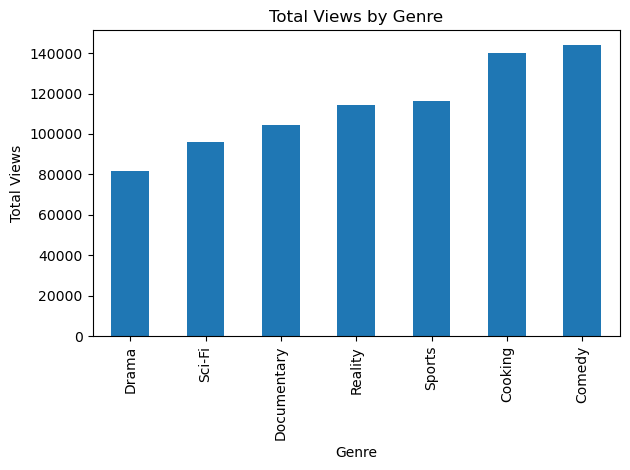

In [22]:
import matplotlib.pyplot as plt

views_by_genre = df.groupby("genre")["views"].sum().sort_values()

views_by_genre.plot(kind="bar")
plt.title("Total Views by Genre")
plt.xlabel("Genre")
plt.ylabel("Total Views")
plt.tight_layout()
plt.show()


### 11.2 Popularity over time

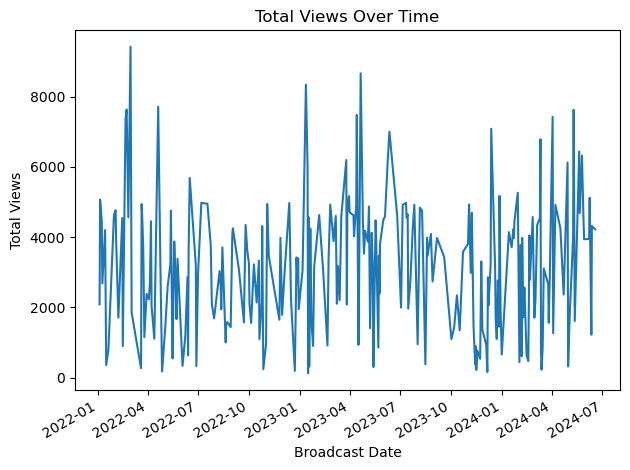

In [23]:
views_over_time = df.groupby("broadcast_date")["views"].sum()

views_over_time.plot()
plt.title("Total Views Over Time")
plt.xlabel("Broadcast Date")
plt.ylabel("Total Views")
plt.tight_layout()
plt.show()


### 11.3 Engagement by `rating`

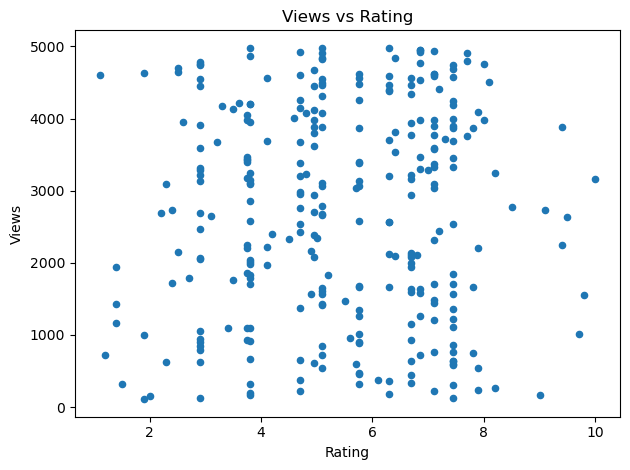

In [24]:
df.plot.scatter(x="rating", y="views")
plt.title("Views vs Rating")
plt.xlabel("Rating")
plt.ylabel("Views")
plt.tight_layout()
plt.show()


### 11.4 Heatmap: Genre × Day-of-Week Views
A heatmap reveals when different genres are most watched.

**Step 1 — Create a day-of-week column**

In [25]:
df["day_of_week"] = df["broadcast_date"].dt.day_name()

**Step 2 — Aggregate views by genre × day**

In [26]:
pivot = df.pivot_table(
    values="views",
    index="genre",
    columns="day_of_week",
    aggfunc="sum",
    fill_value=0
)

**Step 3 — Plot heatmap**

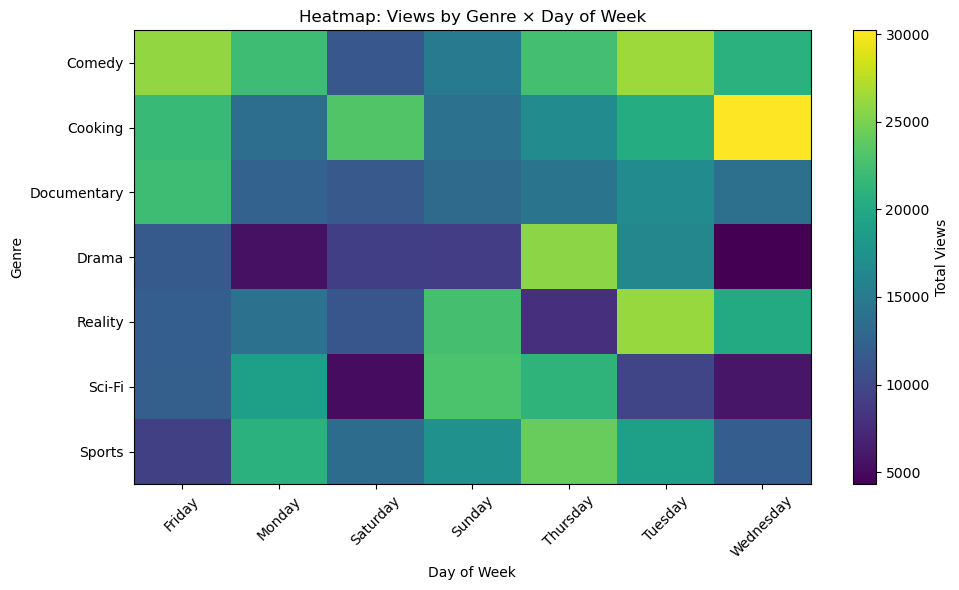

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.imshow(pivot, aspect="auto")
plt.colorbar(label="Total Views")
plt.xticks(range(len(pivot.columns)), pivot.columns, rotation=45)
plt.yticks(range(len(pivot.index)), pivot.index)
plt.title("Heatmap: Views by Genre × Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Genre")
plt.tight_layout()
plt.show()


### 11.5 Top Shows: Top N Titles by Views per Month
This highlights viewing trends and seasonal popularity.

**Step 1 - Extract year-month**

In [28]:
df["year_month"] = df["broadcast_date"].dt.to_period("M")

**Step 2 - Aggregate total monthly views per title**

In [29]:
monthly_title_views = (
    df.groupby(["year_month", "title"])["views"]
      .sum()
      .reset_index()
)

**Step 3 - Function to get top N titles**

In [30]:
def top_titles_per_month(data, N=5):
    return (data
            .sort_values(["year_month", "views"], ascending=[True, False])
            .groupby("year_month")
            .head(N))

**Step 4 - Visualise**

Example for a single month:

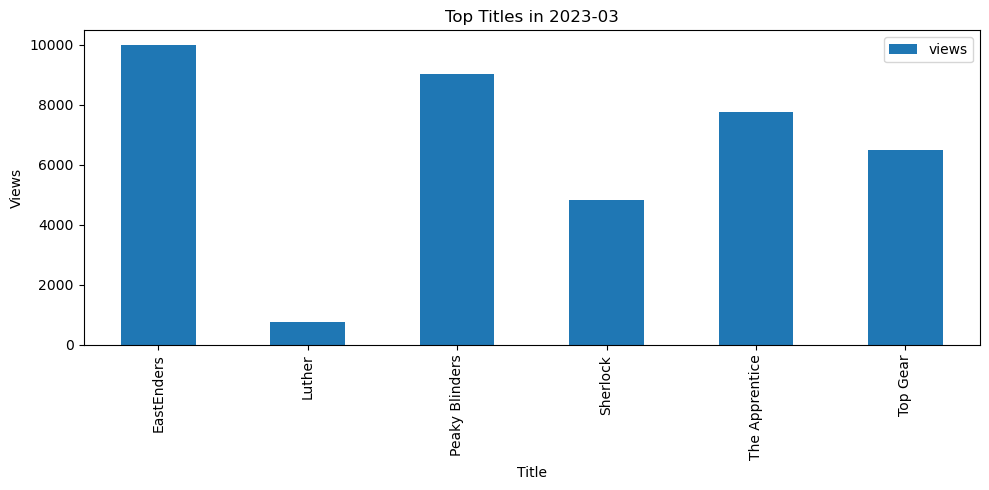

In [31]:
month = "2023-03"  # or any year-month in your dataset
subset = monthly_title_views[monthly_title_views["year_month"] == month]

subset.plot.bar(x="title", y="views", figsize=(10, 5))
plt.title(f"Top Titles in {month}")
plt.ylabel("Views")
plt.xlabel("Title")
plt.tight_layout()
plt.show()


To loop automatically:

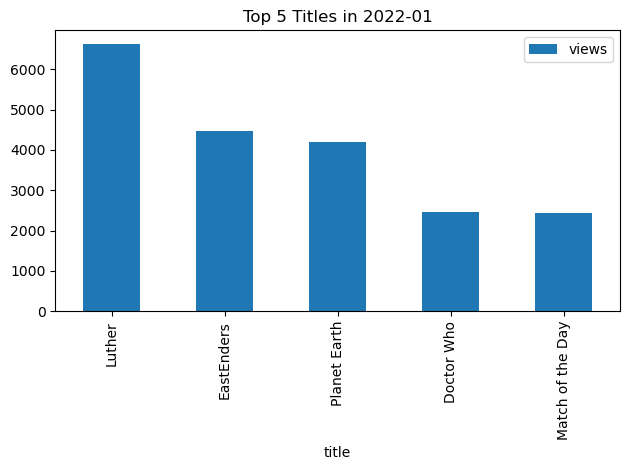

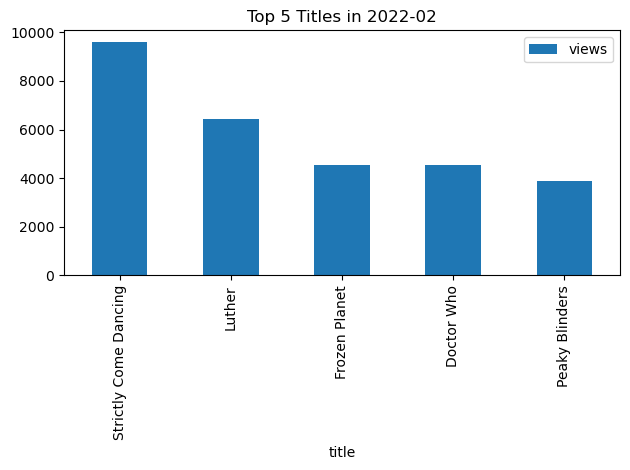

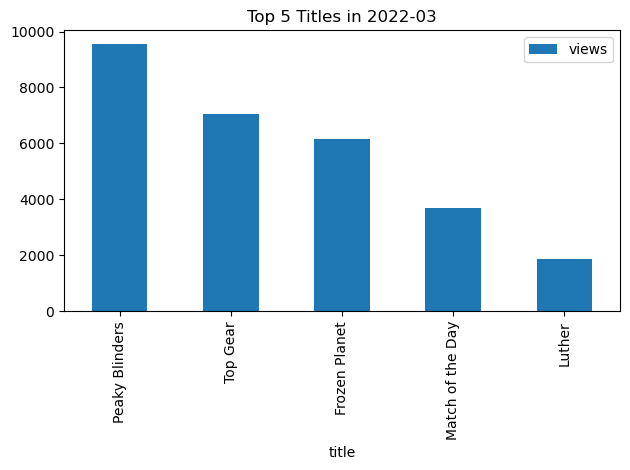

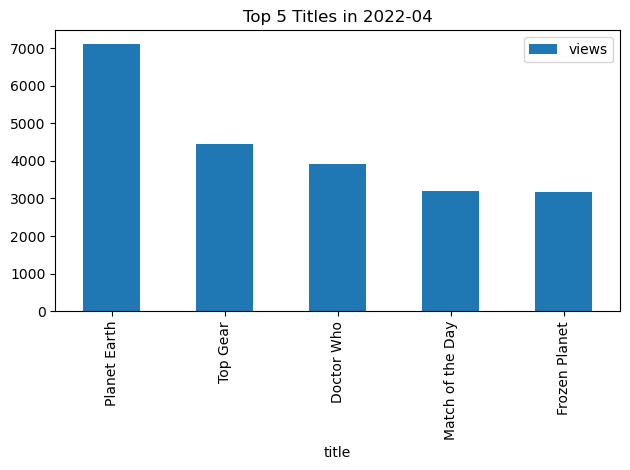

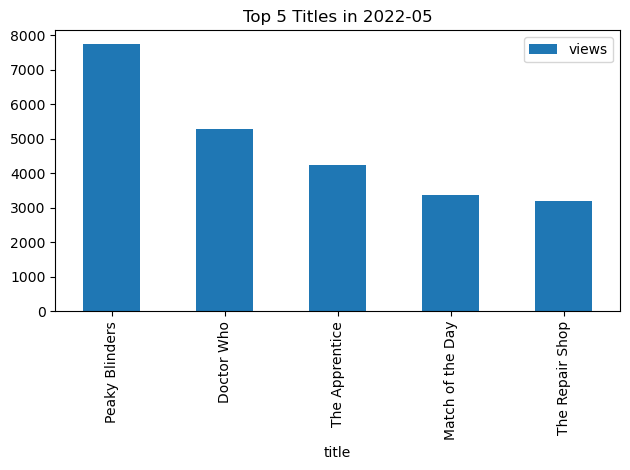

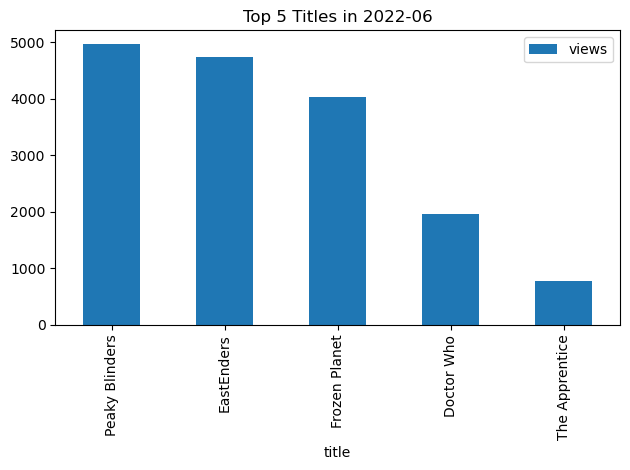

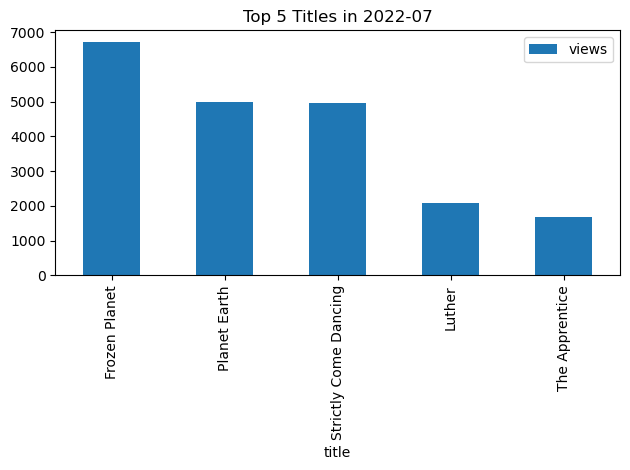

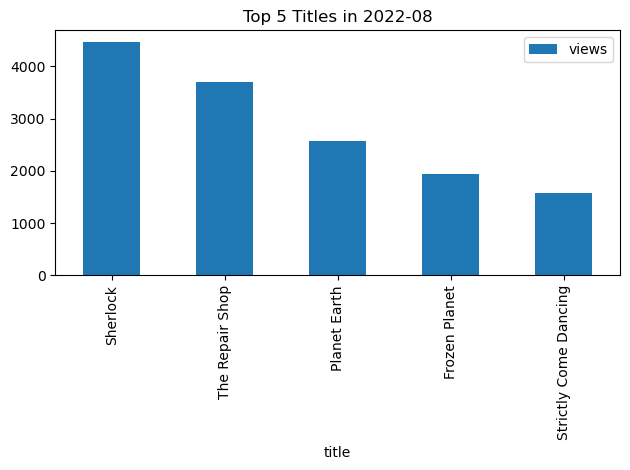

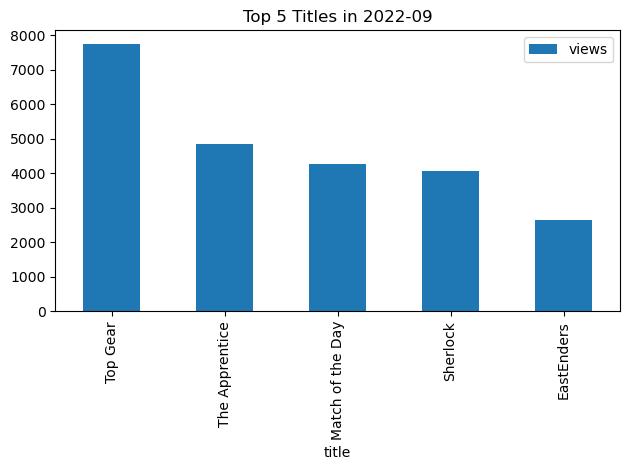

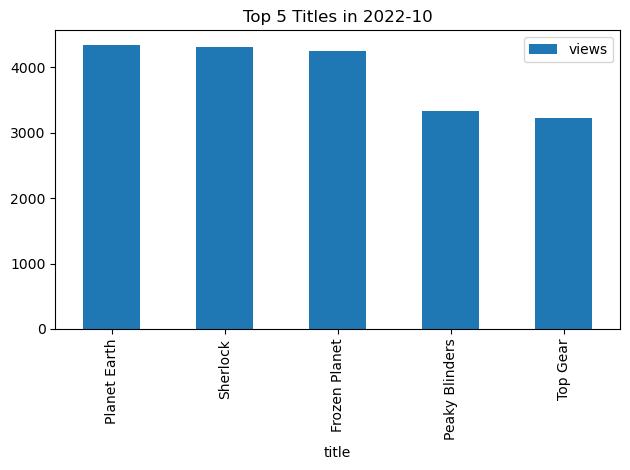

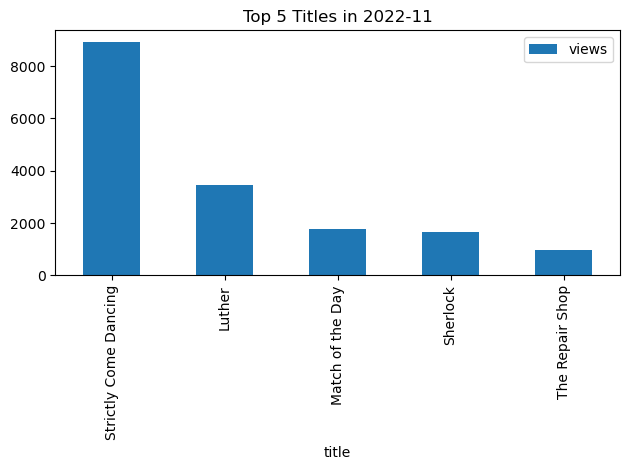

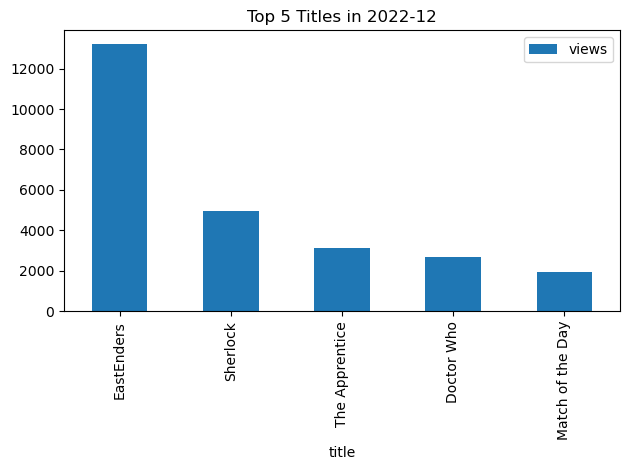

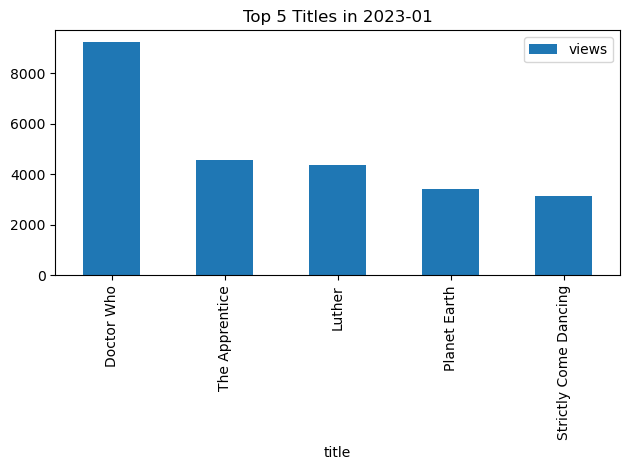

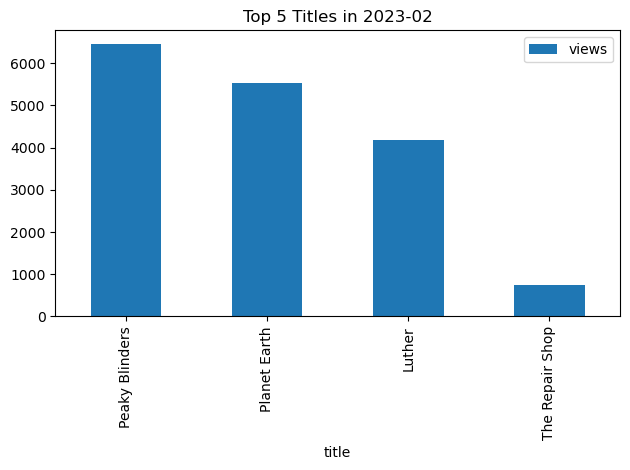

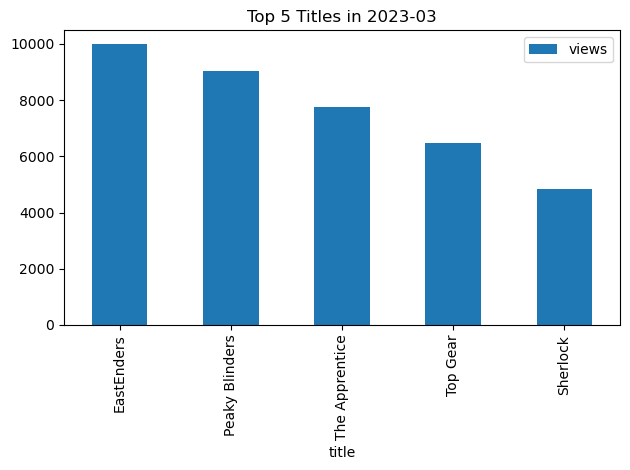

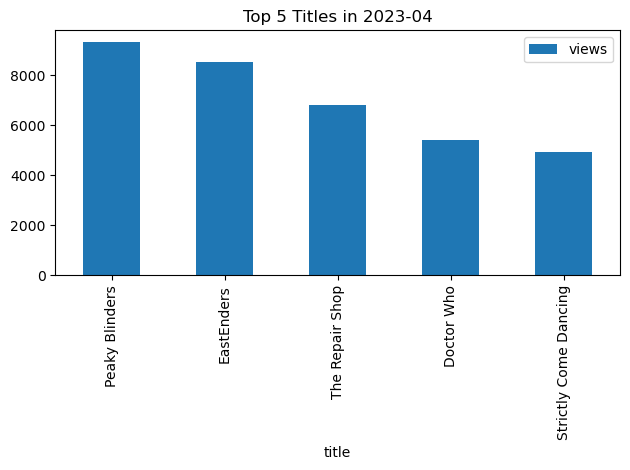

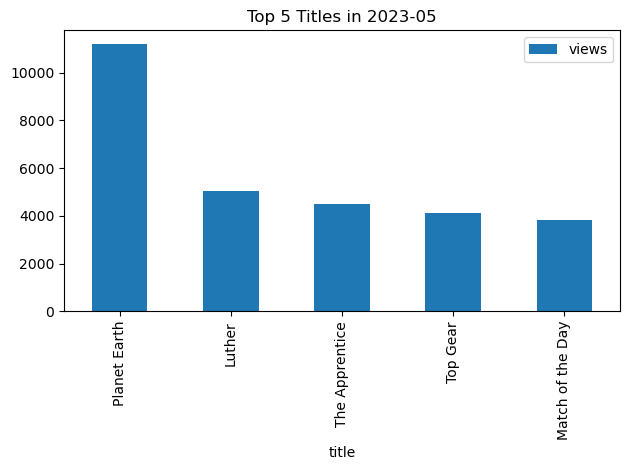

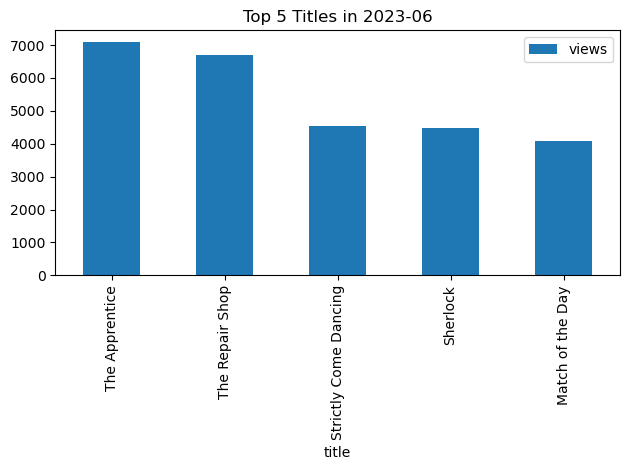

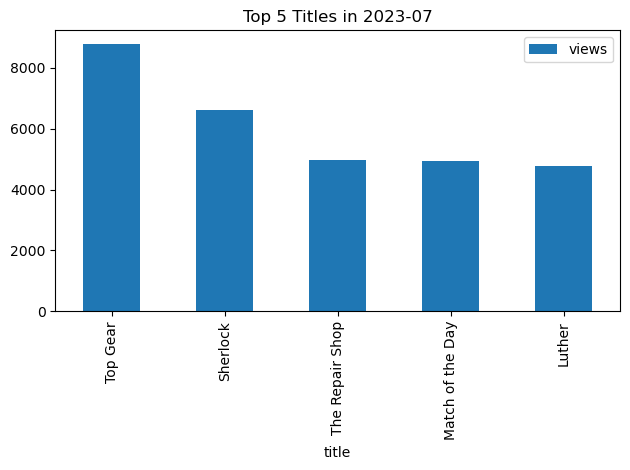

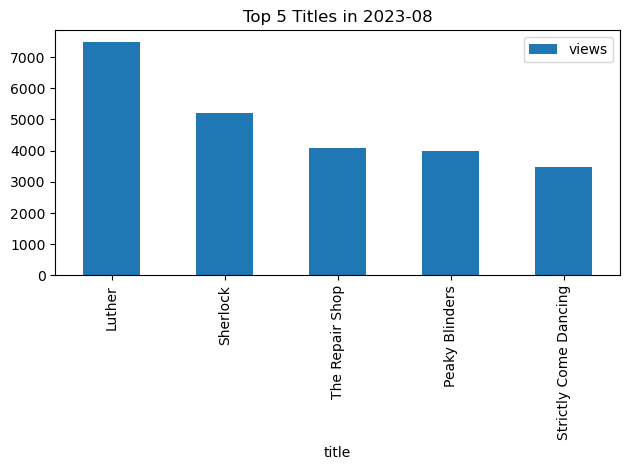

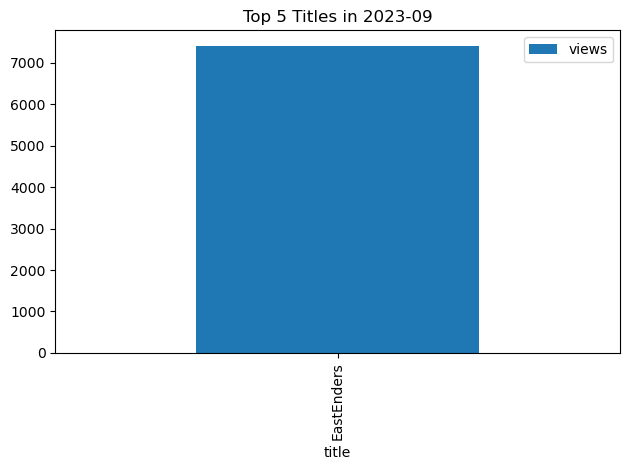

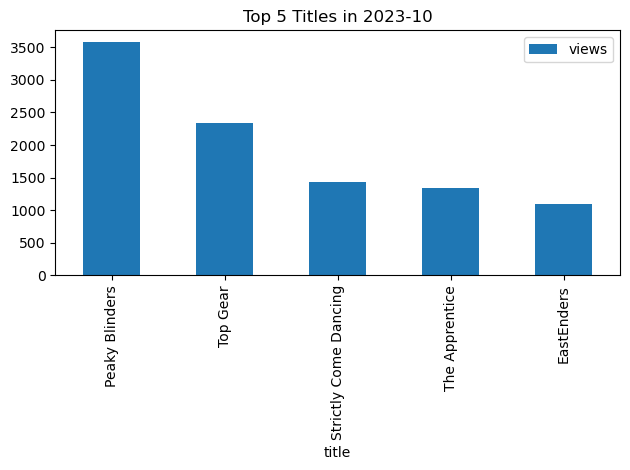

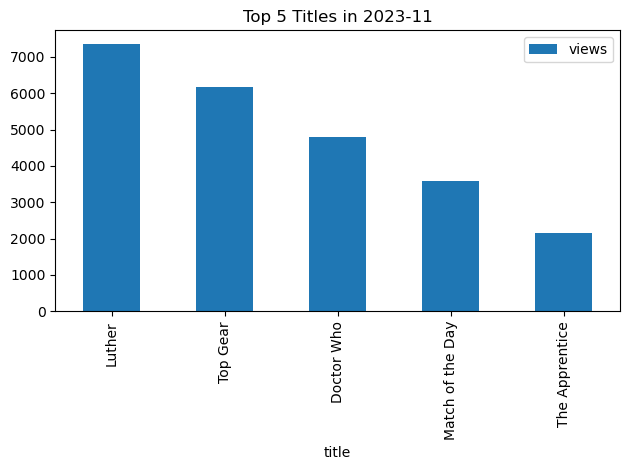

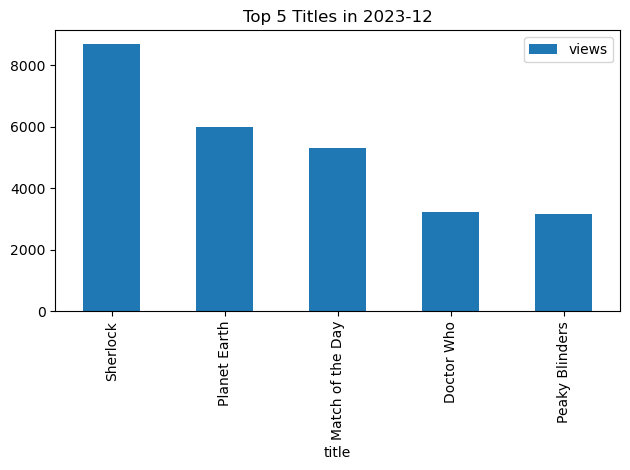

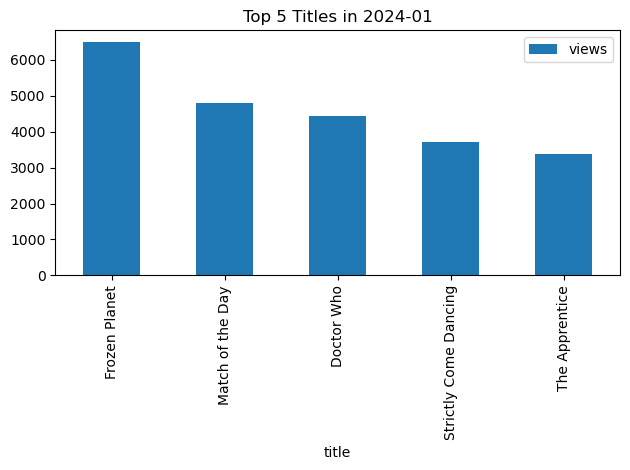

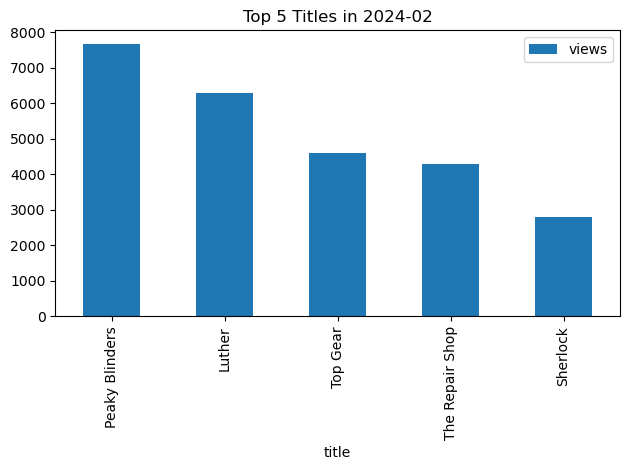

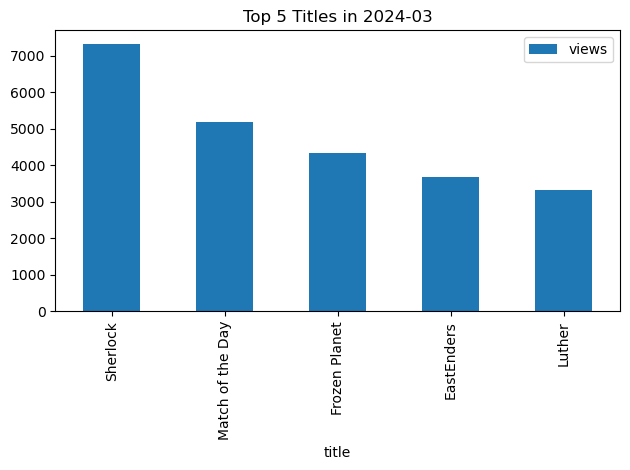

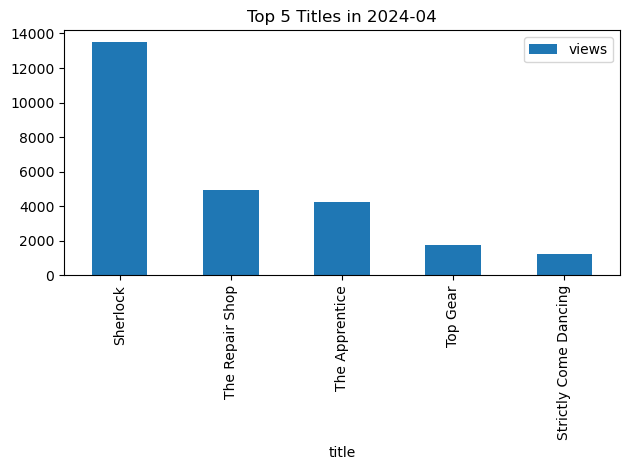

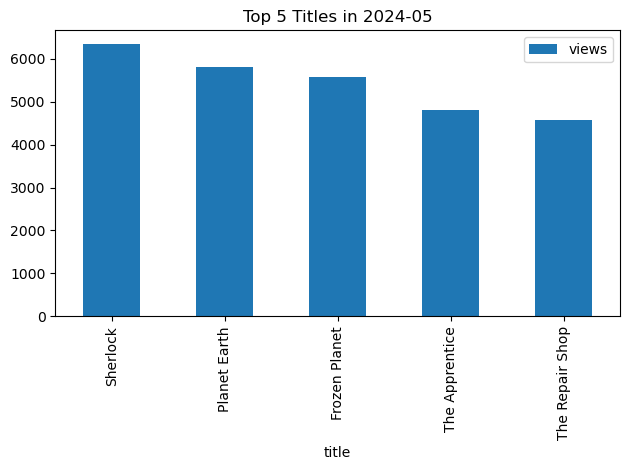

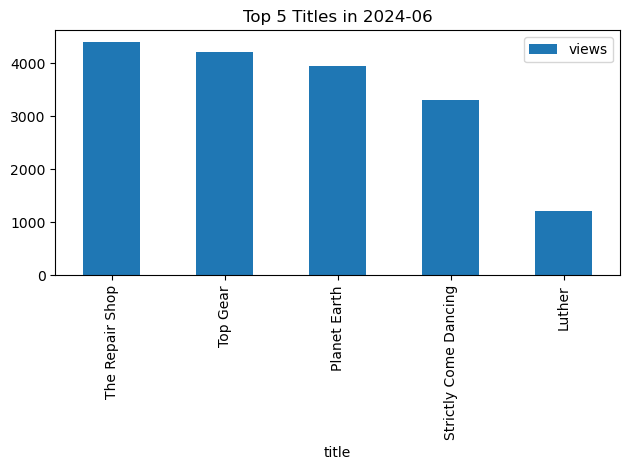

In [32]:
unique_months = sorted(monthly_title_views["year_month"].unique())

for month in unique_months:
    topN = monthly_title_views[monthly_title_views["year_month"] == month].nlargest(5, "views")
    topN.plot.bar(x="title", y="views")
    plt.title(f"Top 5 Titles in {month}")
    plt.tight_layout()
    plt.show()


### 11.6 Session-Like Behaviour (If You Add user_id or device Data)

Expanding the dataset with:

- `user_id`

- `device` (phone, smart TV, console)

- `timestamp` or `session_start`

I can unlock behavioural insights like:

- binge-watching tendencies

- device usage patterns

- session length distributions

- number of shows per session

- peak viewing hours

**Example Schema Extensions**

In [33]:
df["user_id"] = np.random.randint(1, 2000, len(df))
df["device"] = np.random.choice(
    ["Smart TV", "Mobile", "Tablet", "Web", "Console"], len(df)
)
# Optional timestamp instead of broadcast_date
df["timestamp"] = df["broadcast_date"] + pd.to_timedelta(
    np.random.randint(0, 24*60, len(df)), unit="m"
)

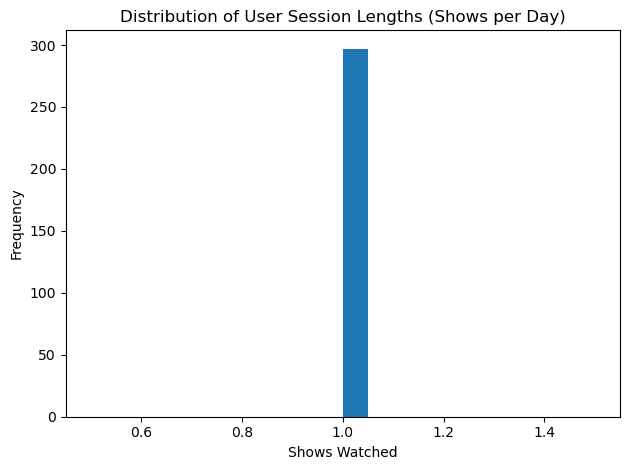

In [34]:
session_lengths = (
    df.groupby(["user_id", df["timestamp"].dt.date])
      .size()
      .reset_index(name="shows_in_session")
)

session_lengths["shows_in_session"].plot.hist(bins=20)
plt.title("Distribution of User Session Lengths (Shows per Day)")
plt.xlabel("Shows Watched")
plt.tight_layout()
plt.show()


#### 11.6.1. Device Usage Patterns

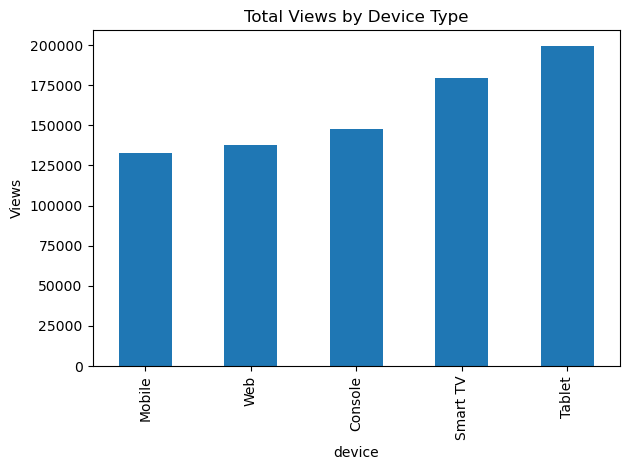

In [35]:
device_views = df.groupby("device")["views"].sum().sort_values()

device_views.plot.bar()
plt.title("Total Views by Device Type")
plt.ylabel("Views")
plt.tight_layout()
plt.show()


#### 11.6.2. Peak Viewing Hours

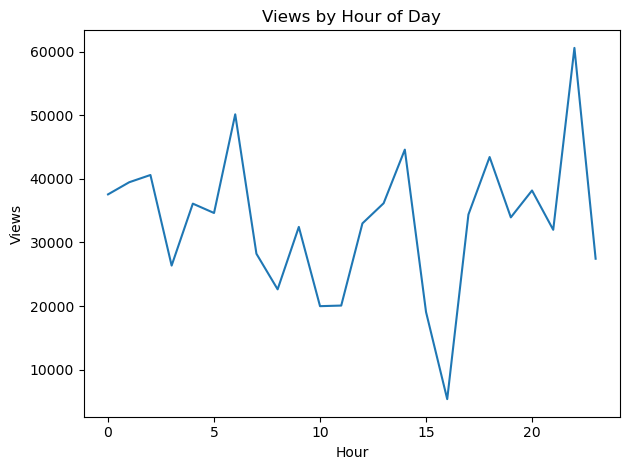

In [36]:
df["hour"] = df["timestamp"].dt.hour

df.groupby("hour")["views"].sum().plot()
plt.title("Views by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Views")
plt.tight_layout()
plt.show()


Analysis Type	Insights You Can Extract

Heatmap (Genre × Day)	Which genres dominate the weekend, weekday evenings, etc.

Top Titles per Month	Seasonal spikes, new trends, release-driven popularity.

Session Behaviour	Binge-watching habits, average user engagement.

Device Patterns	Where people watch (TV vs. mobile) and when.

Hour-based Patterns	Best times for new releases or promotions.